In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif, RFE
import warnings
warnings.filterwarnings('ignore')


plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

In [2]:

df = pd.read_csv('superstore_data.csv')
print(f"Размер датасета: {df.shape}")
print(f"\nИнформация о пропущенных значениях:")
print(df.isnull().sum())


df = df.dropna(subset=['Income'])
print(f"\nРазмер после удаления пропусков: {df.shape}")


print(f"\nРаспределение целевой переменной Response:")
print(df['Response'].value_counts())
print(f"Процент положительных откликов: {df['Response'].mean():.2%}")

Размер датасета: (2240, 22)

Информация о пропущенных значениях:
Id                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
Response                0
Complain                0
dtype: int64

Размер после удаления пропусков: (2216, 22)

Распределение целевой переменной Response:
Response
0    1883
1     333
Name: count, dtype: int64
Процент положительных откликов: 15.03%


In [4]:

df['Age'] = 2025 - df['Year_Birth']
df['Total_Spending'] = (df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + 
                       df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds'])
df['Total_Children'] = df['Kidhome'] + df['Teenhome']
df['Total_Purchases'] = (df['NumWebPurchases'] + df['NumCatalogPurchases'] + 
                        df['NumStorePurchases'] + df['NumDealsPurchases'])
df['Avg_Purchase_Value'] = df['Total_Spending'] / (df['Total_Purchases'] + 1) 
df['Income_per_Person'] = df['Income'] / (df['Total_Children'] + 2) 

print("Созданы дополнительные признаки:")
print("- Age: возраст клиента")
print("- Total_Spending: общие траты")
print("- Total_Children: общее количество детей")
print("- Total_Purchases: общее количество покупок")
print("- Avg_Purchase_Value: средняя стоимость покупки")
print("- Income_per_Person: доход на человека в семье")

Созданы дополнительные признаки:
- Age: возраст клиента
- Total_Spending: общие траты
- Total_Children: общее количество детей
- Total_Purchases: общее количество покупок
- Avg_Purchase_Value: средняя стоимость покупки
- Income_per_Person: доход на человека в семье


In [5]:

categorical_columns = ['Education', 'Marital_Status']
le_dict = {}

for col in categorical_columns:
    le = LabelEncoder()
    df[col + '_encoded'] = le.fit_transform(df[col])
    le_dict[col] = le
    print(f"\n{col} закодирован:")
    for i, category in enumerate(le.classes_):
        print(f"  {category}: {i}")


income_threshold = df['Income'].quantile(0.99)
print(f"\nПорог для доходов (99-й процентиль): {income_threshold:.0f}")
df_clean = df[df['Income'] <= income_threshold].copy()
print(f"Удалено выбросов: {len(df) - len(df_clean)}")
print(f"Размер после очистки: {df_clean.shape}")


Education закодирован:
  2n Cycle: 0
  Basic: 1
  Graduation: 2
  Master: 3
  PhD: 4

Marital_Status закодирован:
  Absurd: 0
  Alone: 1
  Divorced: 2
  Married: 3
  Single: 4
  Together: 5
  Widow: 6
  YOLO: 7

Порог для доходов (99-й процентиль): 94459
Удалено выбросов: 23
Размер после очистки: (2193, 30)


In [6]:
feature_columns = [
    'Age', 'Education_encoded', 'Marital_Status_encoded', 'Income',
    'Kidhome', 'Teenhome', 'Total_Children', 'Recency',
    'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 
    'MntSweetProducts', 'MntGoldProds', 'Total_Spending',
    'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 
    'NumStorePurchases', 'Total_Purchases', 'NumWebVisitsMonth',
    'Avg_Purchase_Value', 'Income_per_Person', 'Complain'
]

X = df_clean[feature_columns].copy()
y = df_clean['Response'].copy()

print(f"Количество признаков: {X.shape[1]}")
print(f"Размер выборки: {X.shape[0]}")
print(f"\nПризнаки для модели:")
for i, col in enumerate(X.columns, 1):
    print(f"{i:2d}. {col}")

Количество признаков: 24
Размер выборки: 2193

Признаки для модели:
 1. Age
 2. Education_encoded
 3. Marital_Status_encoded
 4. Income
 5. Kidhome
 6. Teenhome
 7. Total_Children
 8. Recency
 9. MntWines
10. MntFruits
11. MntMeatProducts
12. MntFishProducts
13. MntSweetProducts
14. MntGoldProds
15. Total_Spending
16. NumDealsPurchases
17. NumWebPurchases
18. NumCatalogPurchases
19. NumStorePurchases
20. Total_Purchases
21. NumWebVisitsMonth
22. Avg_Purchase_Value
23. Income_per_Person
24. Complain


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")
print(f"\nРаспределение целевой переменной в обучающей выборке:")
print(y_train.value_counts(normalize=True))
print(f"\nРаспределение целевой переменной в тестовой выборке:")
print(y_test.value_counts(normalize=True))


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nДанные масштабированы с помощью StandardScaler")
print(f"Среднее значение признаков в обучающей выборке: {X_train_scaled.mean():.6f}")
print(f"Стандартное отклонение признаков в обучающей выборке: {X_train_scaled.std():.6f}")

Размер обучающей выборки: (1754, 24)
Размер тестовой выборки: (439, 24)

Распределение целевой переменной в обучающей выборке:
Response
0    0.852908
1    0.147092
Name: proportion, dtype: float64

Распределение целевой переменной в тестовой выборке:
Response
0    0.851936
1    0.148064
Name: proportion, dtype: float64

Данные масштабированы с помощью StandardScaler
Среднее значение признаков в обучающей выборке: -0.000000
Стандартное отклонение признаков в обучающей выборке: 1.000000


In [8]:
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)


y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

print("Базовая модель логистической регрессии обучена")

Базовая модель логистической регрессии обучена


In [9]:
def evaluate_model(y_true, y_pred, y_pred_proba, model_name):
    """Функция для оценки качества модели"""
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    
    print(f"\n=== Оценка качества модели: {model_name} ===")
    print(f"Accuracy (Точность):     {accuracy:.4f}")
    print(f"Precision (Точность):    {precision:.4f}")
    print(f"Recall (Полнота):        {recall:.4f}")
    print(f"F1-score:                {f1:.4f}")
    print(f"ROC-AUC:                 {roc_auc:.4f}")
    
    return {
        'model': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc
    }


lr_results = evaluate_model(y_test, y_pred_lr, y_pred_proba_lr, "Логистическая регрессия")


=== Оценка качества модели: Логистическая регрессия ===
Accuracy (Точность):     0.8610
Precision (Точность):    0.5588
Recall (Полнота):        0.2923
F1-score:                0.3838
ROC-AUC:                 0.8492


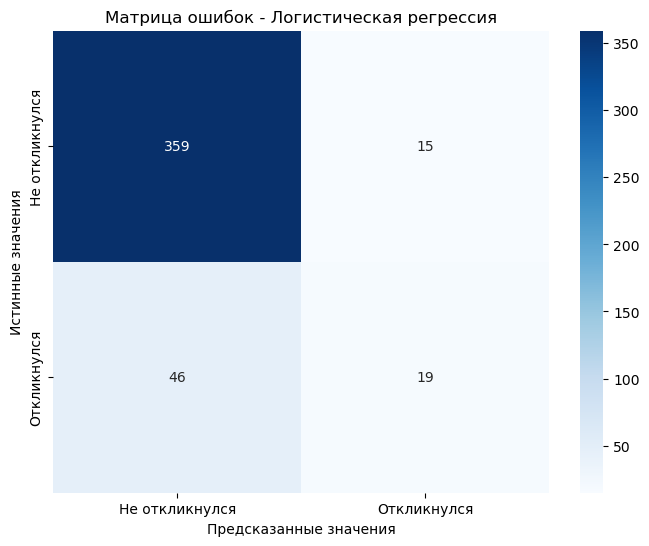


Детальный отчет о классификации:
                precision    recall  f1-score   support

Не откликнулся       0.89      0.96      0.92       374
   Откликнулся       0.56      0.29      0.38        65

      accuracy                           0.86       439
     macro avg       0.72      0.63      0.65       439
  weighted avg       0.84      0.86      0.84       439



In [10]:

cm = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Не откликнулся', 'Откликнулся'],
            yticklabels=['Не откликнулся', 'Откликнулся'])
plt.title('Матрица ошибок - Логистическая регрессия')
plt.ylabel('Истинные значения')
plt.xlabel('Предсказанные значения')
plt.show()


print("\nДетальный отчет о классификации:")
print(classification_report(y_test, y_pred_lr, target_names=['Не откликнулся', 'Откликнулся']))

Топ-10 наиболее важных признаков (по абсолютному значению коэффициента):
            feature  coefficient  abs_coefficient
  Income_per_Person     1.906981         1.906981
             Income    -0.827708         0.827708
  NumWebVisitsMonth     0.747801         0.747801
            Recency    -0.720164         0.720164
  NumStorePurchases    -0.687452         0.687452
            Kidhome     0.383164         0.383164
NumCatalogPurchases     0.358089         0.358089
           MntWines     0.328811         0.328811
  NumDealsPurchases     0.321542         0.321542
  Education_encoded     0.293790         0.293790


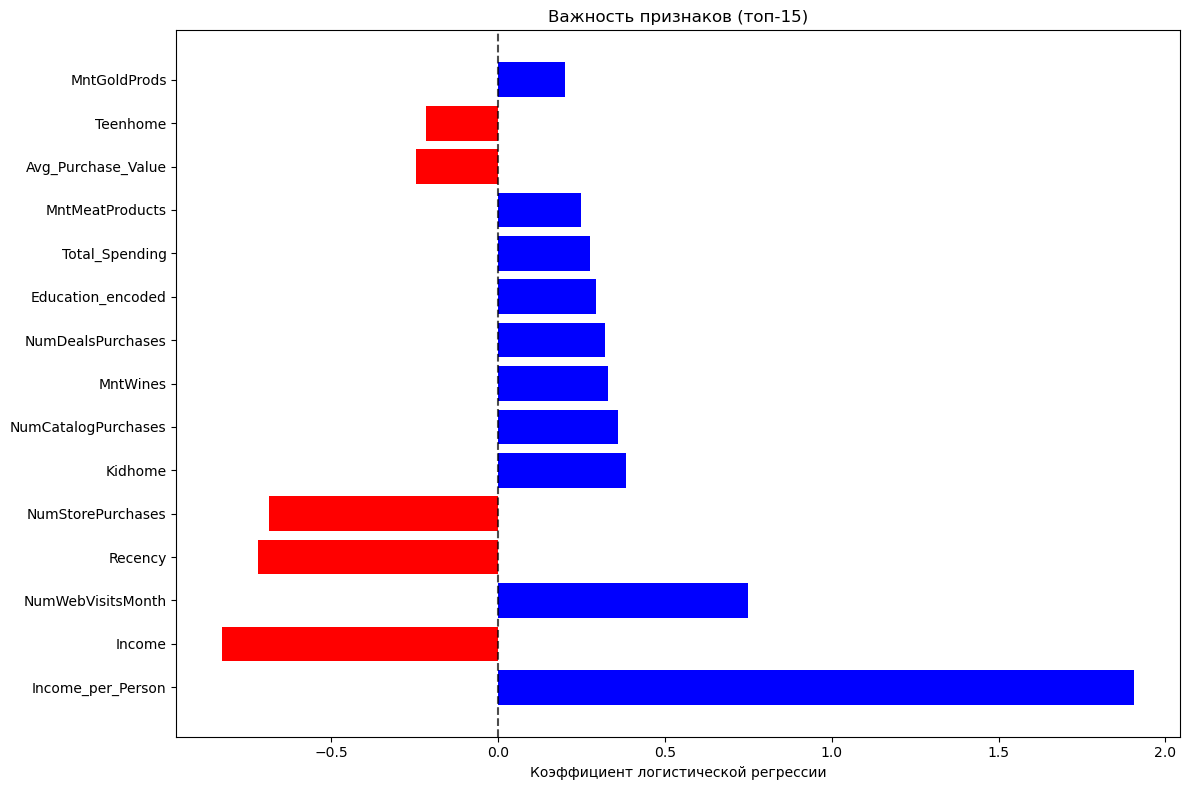

In [11]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'coefficient': lr_model.coef_[0],
    'abs_coefficient': np.abs(lr_model.coef_[0])
})

feature_importance = feature_importance.sort_values('abs_coefficient', ascending=False)

print("Топ-10 наиболее важных признаков (по абсолютному значению коэффициента):")
print(feature_importance.head(10).to_string(index=False))


plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
colors = ['red' if x < 0 else 'blue' for x in top_features['coefficient']]
plt.barh(range(len(top_features)), top_features['coefficient'], color=colors)
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Коэффициент логистической регрессии')
plt.title('Важность признаков (топ-15)')
plt.axvline(x=0, color='black', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [12]:

print("=== ОБУЧЕНИЕ ДЕРЕВА РЕШЕНИЙ ===")
dt_model = DecisionTreeClassifier(random_state=42, max_depth=10, min_samples_split=20)
dt_model.fit(X_train, y_train)  
y_pred_dt = dt_model.predict(X_test)
y_pred_proba_dt = dt_model.predict_proba(X_test)[:, 1]
dt_results = evaluate_model(y_test, y_pred_dt, y_pred_proba_dt, "Дерево решений")


print("\n=== ОБУЧЕНИЕ СЛУЧАЙНОГО ЛЕСА ===")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=15)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]
rf_results = evaluate_model(y_test, y_pred_rf, y_pred_proba_rf, "Случайный лес")


print("\n=== ОБУЧЕНИЕ ГРАДИЕНТНОГО БУСТИНГА ===")
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42, max_depth=6)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)
y_pred_proba_gb = gb_model.predict_proba(X_test)[:, 1]
gb_results = evaluate_model(y_test, y_pred_gb, y_pred_proba_gb, "Градиентный бустинг")

=== ОБУЧЕНИЕ ДЕРЕВА РЕШЕНИЙ ===

=== Оценка качества модели: Дерево решений ===
Accuracy (Точность):     0.8269
Precision (Точность):    0.3922
Recall (Полнота):        0.3077
F1-score:                0.3448
ROC-AUC:                 0.7146

=== ОБУЧЕНИЕ СЛУЧАЙНОГО ЛЕСА ===

=== Оценка качества модели: Случайный лес ===
Accuracy (Точность):     0.8747
Precision (Точность):    0.6667
Recall (Полнота):        0.3077
F1-score:                0.4211
ROC-AUC:                 0.8471

=== ОБУЧЕНИЕ ГРАДИЕНТНОГО БУСТИНГА ===

=== Оценка качества модели: Градиентный бустинг ===
Accuracy (Точность):     0.8679
Precision (Точность):    0.5897
Recall (Полнота):        0.3538
F1-score:                0.4423
ROC-AUC:                 0.8520


In [13]:

print("=== ОТБОР ПРИЗНАКОВ SelectKBest ===")
k_best = SelectKBest(score_func=f_classif, k=15)
X_train_kbest = k_best.fit_transform(X_train_scaled, y_train)
X_test_kbest = k_best.transform(X_test_scaled)


selected_features_kbest = X.columns[k_best.get_support()]
print(f"Выбрано {len(selected_features_kbest)} признаков с помощью SelectKBest:")
print(list(selected_features_kbest))


lr_kbest = LogisticRegression(random_state=42, max_iter=1000)
lr_kbest.fit(X_train_kbest, y_train)
y_pred_kbest = lr_kbest.predict(X_test_kbest)
y_pred_proba_kbest = lr_kbest.predict_proba(X_test_kbest)[:, 1]

lr_kbest_results = evaluate_model(y_test, y_pred_kbest, y_pred_proba_kbest, "ЛР с SelectKBest")

=== ОТБОР ПРИЗНАКОВ SelectKBest ===
Выбрано 15 признаков с помощью SelectKBest:
['Income', 'Teenhome', 'Total_Children', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntSweetProducts', 'MntGoldProds', 'Total_Spending', 'NumWebPurchases', 'NumCatalogPurchases', 'Total_Purchases', 'Avg_Purchase_Value', 'Income_per_Person']

=== Оценка качества модели: ЛР с SelectKBest ===
Accuracy (Точность):     0.8588
Precision (Точность):    0.5714
Recall (Полнота):        0.1846
F1-score:                0.2791
ROC-AUC:                 0.8150


In [14]:


param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 15, 20],
    'min_samples_split': [10, 20],
    'min_samples_leaf': [5, 10]
}

print("=== ОПТИМИЗАЦИЯ ГИПЕРПАРАМЕТРОВ ===")
print("Начинаем поиск лучших гиперпараметров для случайного леса...")
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), 
                       param_grid_rf, cv=5, scoring='roc_auc', n_jobs=-1)
rf_grid.fit(X_train, y_train)

print(f"Лучшие параметры: {rf_grid.best_params_}")
print(f"Лучший ROC-AUC на валидации: {rf_grid.best_score_:.4f}")


y_pred_rf_opt = rf_grid.predict(X_test)
y_pred_proba_rf_opt = rf_grid.predict_proba(X_test)[:, 1]
rf_opt_results = evaluate_model(y_test, y_pred_rf_opt, y_pred_proba_rf_opt, "Случайный лес (оптимизированный)")

=== ОПТИМИЗАЦИЯ ГИПЕРПАРАМЕТРОВ ===
Начинаем поиск лучших гиперпараметров для случайного леса...
Лучшие параметры: {'max_depth': 20, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 200}
Лучший ROC-AUC на валидации: 0.8552

=== Оценка качества модели: Случайный лес (оптимизированный) ===
Accuracy (Точность):     0.8656
Precision (Точность):    0.6667
Recall (Полнота):        0.1846
F1-score:                0.2892
ROC-AUC:                 0.8296



=== СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ ===
                              model  accuracy  precision  recall      f1  \
4               Градиентный бустинг    0.8679     0.5897  0.3538  0.4423   
0           Логистическая регрессия    0.8610     0.5588  0.2923  0.3838   
3                     Случайный лес    0.8747     0.6667  0.3077  0.4211   
5  Случайный лес (оптимизированный)    0.8656     0.6667  0.1846  0.2892   
1                  ЛР с SelectKBest    0.8588     0.5714  0.1846  0.2791   
2                    Дерево решений    0.8269     0.3922  0.3077  0.3448   

   roc_auc  
4   0.8520  
0   0.8492  
3   0.8471  
5   0.8296  
1   0.8150  
2   0.7146  


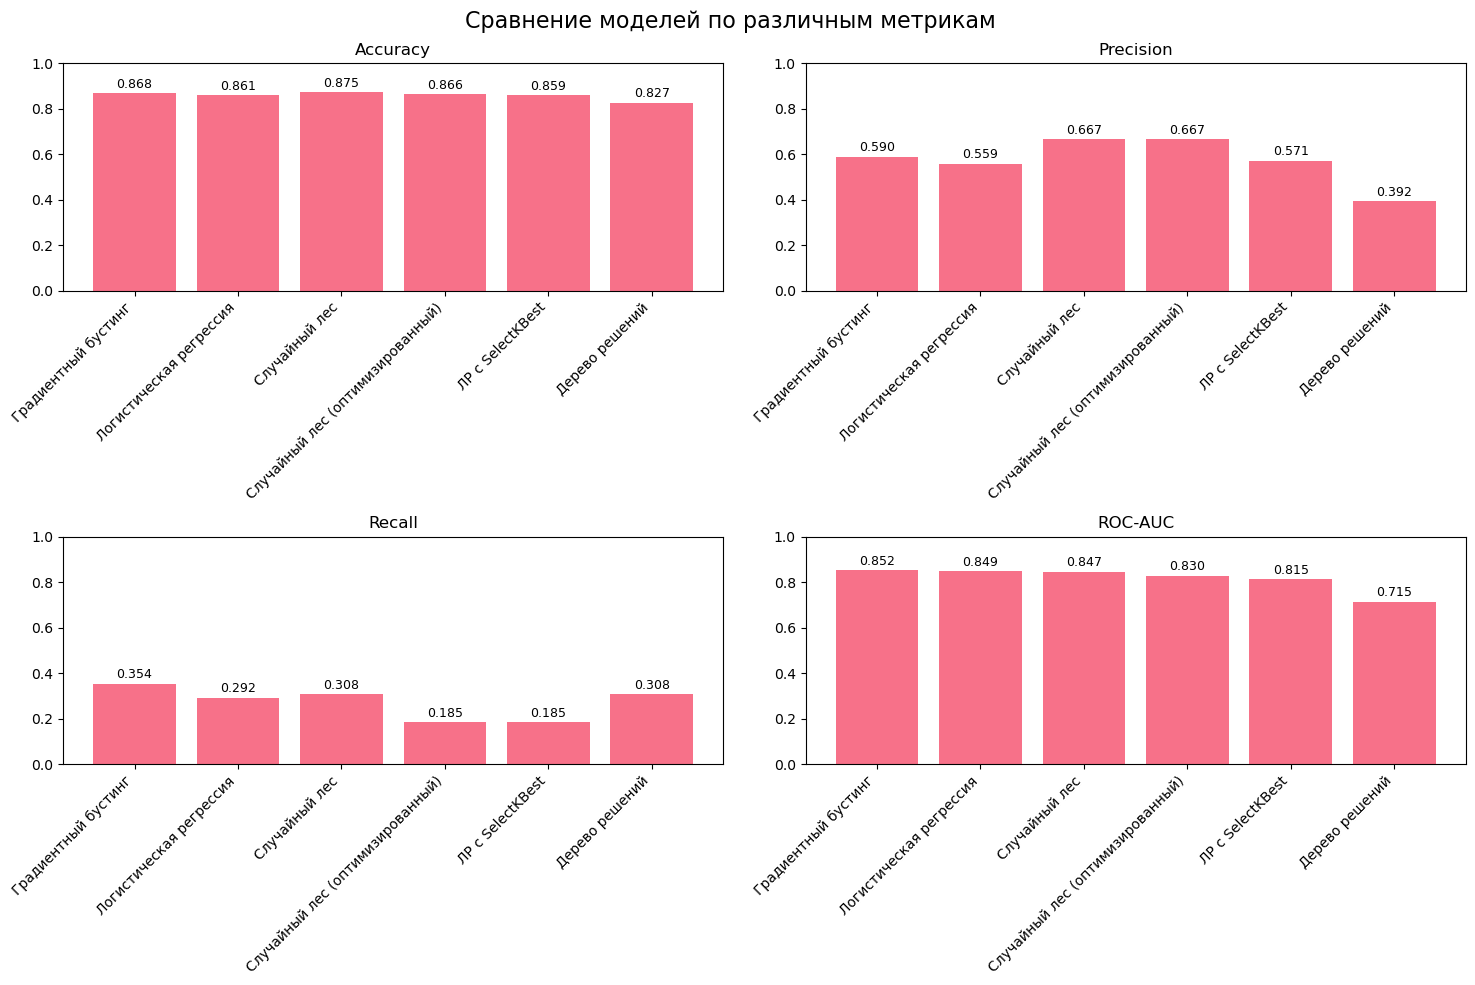

In [15]:

all_results = [
    lr_results,
    lr_kbest_results,
    dt_results,
    rf_results,
    gb_results,
    rf_opt_results
]

results_df = pd.DataFrame(all_results)
results_df = results_df.sort_values('roc_auc', ascending=False)

print("\n=== СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ ===")
print(results_df.round(4))

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Сравнение моделей по различным метрикам', fontsize=16)

metrics = ['accuracy', 'precision', 'recall', 'roc_auc']
metric_names = ['Accuracy', 'Precision', 'Recall', 'ROC-AUC']

for i, (metric, name) in enumerate(zip(metrics, metric_names)):
    ax = axes[i//2, i%2]
    bars = ax.bar(range(len(results_df)), results_df[metric])
    ax.set_title(name)
    ax.set_xticks(range(len(results_df)))
    ax.set_xticklabels(results_df['model'], rotation=45, ha='right')
    ax.set_ylim(0, 1)
    
    
    for bar, value in zip(bars, results_df[metric]):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{value:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

Топ-15 наиболее важных признаков (случайный лес):
            feature  importance
            Recency    0.104594
 Avg_Purchase_Value    0.091333
  Income_per_Person    0.080977
             Income    0.072289
     Total_Spending    0.071834
           MntWines    0.070765
    MntMeatProducts    0.063417
       MntGoldProds    0.052392
  NumWebVisitsMonth    0.045375
  NumStorePurchases    0.044006
NumCatalogPurchases    0.037144
                Age    0.034075
    MntFishProducts    0.034005
          MntFruits    0.033208
   MntSweetProducts    0.032599


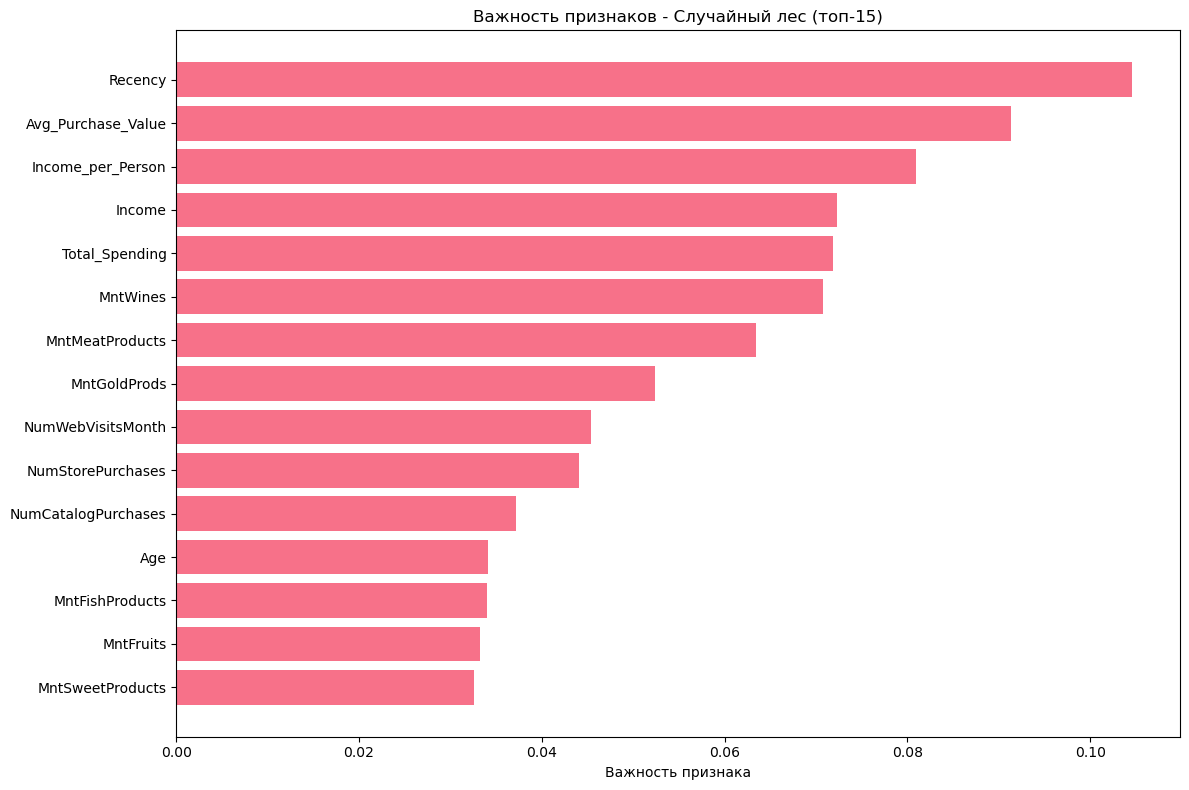

In [16]:


best_model = rf_grid.best_estimator_


feature_importance_rf = pd.DataFrame({
    'feature': X.columns,
    'importance': best_model.feature_importances_
})

feature_importance_rf = feature_importance_rf.sort_values('importance', ascending=False)

print("Топ-15 наиболее важных признаков (случайный лес):")
print(feature_importance_rf.head(15).to_string(index=False))


plt.figure(figsize=(12, 8))
top_15_features = feature_importance_rf.head(15)
plt.barh(range(len(top_15_features)), top_15_features['importance'])
plt.yticks(range(len(top_15_features)), top_15_features['feature'])
plt.xlabel('Важность признака')
plt.title('Важность признаков - Случайный лес (топ-15)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [18]:
best_model_name = results_df.iloc[0]['model']
best_roc_auc = results_df.iloc[0]['roc_auc']

print(f"\n1. ЛУЧШАЯ МОДЕЛЬ: {best_model_name}")
print(f"   ROC-AUC: {best_roc_auc:.4f}")
print(f"   Precision: {results_df.iloc[0]['precision']:.4f}")
print(f"   Recall: {results_df.iloc[0]['recall']:.4f}")
print(f"   F1-score: {results_df.iloc[0]['f1']:.4f}")

print("\n2. МЕТРИКИ:")
print("   - Accuracy: доля правильных предсказаний")
print("   - Precision: доля истинно положительных среди предсказанных положительных")
print("   - Recall: доля найденных положительных случаев")
print("   - F1-score: гармоническое среднее precision и recall")
print("   - ROC-AUC: площадь под ROC-кривой")

print("\n3. НАИБОЛЕЕ ЗНАЧИМЫЕ ПРИЗНАКИ:")
top_5_features = feature_importance_rf.head(5)
for i, (_, row) in enumerate(top_5_features.iterrows(), 1):
    print(f"   {i}. {row['feature']}: {row['importance']:.4f}")


print("\n5. ДОСТИГНУТОЕ КАЧЕСТВО:")
baseline_auc = lr_results['roc_auc']
improvement = (best_roc_auc - baseline_auc) / baseline_auc * 100
print(f"   Базовая модель (ЛР): ROC-AUC = {baseline_auc:.4f}")
print(f"   Лучшая модель: ROC-AUC = {best_roc_auc:.4f}")
print(f"   Улучшение: +{improvement:.1f}%")




1. ЛУЧШАЯ МОДЕЛЬ: Градиентный бустинг
   ROC-AUC: 0.8520
   Precision: 0.5897
   Recall: 0.3538
   F1-score: 0.4423

2. МЕТРИКИ:
   - Accuracy: доля правильных предсказаний
   - Precision: доля истинно положительных среди предсказанных положительных
   - Recall: доля найденных положительных случаев
   - F1-score: гармоническое среднее precision и recall
   - ROC-AUC: площадь под ROC-кривой

3. НАИБОЛЕЕ ЗНАЧИМЫЕ ПРИЗНАКИ:
   1. Recency: 0.1046
   2. Avg_Purchase_Value: 0.0913
   3. Income_per_Person: 0.0810
   4. Income: 0.0723
   5. Total_Spending: 0.0718

5. ДОСТИГНУТОЕ КАЧЕСТВО:
   Базовая модель (ЛР): ROC-AUC = 0.8492
   Лучшая модель: ROC-AUC = 0.8520
   Улучшение: +0.3%
